## Imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import helper_utils

helper_utils.set_seed(42)

In [2]:
# # Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)
         
    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def evaluate_accuracy(model, val_loader, device):
    """Calculates the accuracy of a model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        val_loader (DataLoader): The DataLoader containing the validation or test data.
        device: The device (e.g., 'cuda' or 'cpu') to perform the evaluation on.

    Returns:
        float: The computed accuracy of the model on the dataset.
    """
    # Set the model to evaluation mode
    model.eval()
    # Initialize counters for accuracy calculation
    total_correct = 0
    total_samples = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the provided loader
        for inputs, labels in val_loader:
            # Move input and label tensors to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Perform a forward pass to get model outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index of the maximum logit
            _, predicted = outputs.max(1)
            # Update the count of correctly classified samples
            total_correct += (predicted == labels).sum().item()
            # Update the total number of samples processed
            total_samples += labels.size(0)

    # Calculate the final accuracy
    accuracy = total_correct / total_samples
    # Return the computed accuracy
    return accuracy

In [4]:
def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model for a specific learning rate and configuration.

    This function orchestrates the entire workflow: it sets a random seed,
    initializes the model, optimizer, and dataloaders, trains the model,
    and finally evaluates its accuracy on a validation set.

    Args:
        learning_rate (float): The learning rate to use for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of epochs for training. Defaults to 25.
        batch_size (int, optional): The batch size for the dataloaders. Defaults to 128.

    Returns:
        float: The final validation accuracy of the trained model.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Call the main training loop to train the model
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evaluate the trained model's accuracy on the validation set
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    # Print the final results for this configuration
    print(f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}")
    # Return the computed accuracy
    return accuracy

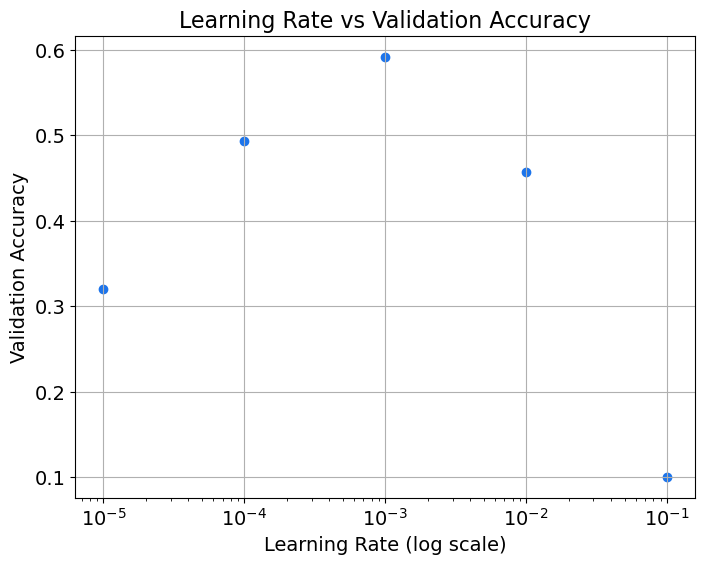

In [6]:
helper_utils.plot_results(learning_rates, accuracies)

In [7]:
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evaluates the model on a given dataset using multiple metrics.

    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        val_dataloader (DataLoader): The DataLoader containing the validation data.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the evaluation on.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.

    Returns:
        tuple: A tuple containing the computed accuracy, precision, recall, and F1 score.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### START CODE HERE ###
    
    # Initialize precision metric  using `torchmetrics.Precision`
    precision_metric = torchmetrics.Precision(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize recall metric using `torchmetrics.Recall`
    recall_metric = torchmetrics.Recall(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize F1 score metric using `torchmetrics.F1Score`
    f1_metric = torchmetrics.F1Score(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### END CODE HERE ###

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataloader
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Get model predictions
            outputs = model(inputs)
            # Get the predicted class by finding the index of the maximum logit
            _, predicted = torch.max(outputs, 1)

            # Update metrics with the predictions and true labels for the current batch
            accuracy_metric.update(predicted, labels)
            
    ### START CODE HERE ###
            
            # Update `precision_metric` using `.update` method 
            precision_metric.update(predicted, labels)
            
            # Update `recall_metric` using `.update` method
            recall_metric.update(predicted, labels)
            
            # Update `f1_metric` using `.update` method
            f1_metric.update(predicted, labels)

    # Compute the final metrics over the entire dataset
    accuracy = accuracy_metric.compute().item()
    
    # Compute precision using `.compute` method and get the value with `.item()`
    precision = precision_metric.compute().item()
    
    # Compute recall using `.compute` method and get the value with `.item()`
    recall = recall_metric.compute().item()
    
    # Compute F1 score using `.compute` method and get the value with `.item()`
    f1 = f1_metric.compute().item()
    
    ### END CODE HERE ###

    return accuracy, precision, recall, f1

In [8]:
# CHECK YOUR IMPLEMENTATION

# model
model = SimpleCNN().to(device)

# dataloaders
train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=128)

accuracy, precision, recall, f1 = evaluate_metrics(model=model, val_dataloader=val_dataloader, device=device)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.1000, Precision: 0.0103, Recall: 0.1000, F1 Score: 0.0187


In [9]:
def train_and_evaluate_metrics(learning_rate, device, n_epochs=25, batch_size=128, imbalanced=False):
    """Trains and evaluates a model, returning a comprehensive set of metrics.

    This function orchestrates the end-to-end machine learning pipeline for a
    given configuration. It sets a random seed, initializes the model and
    related components, loads data, runs the training loop, and evaluates
    the model's performance using accuracy, precision, recall, and F1-score.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        imbalanced (bool, optional): A flag to use an imbalanced dataset.
                                     Defaults to False.

    Returns:
        tuple: A tuple containing the final validation accuracy, precision,
               recall, and F1-score.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function for training
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size, imbalanced=imbalanced)

    # Call the main training loop to train the model
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evaluate the trained model to get a full set of performance metrics
    accuracy, precision, recall, f1 = evaluate_metrics(model, val_dataloader, device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
    )
    # Return the computed performance metrics
    return accuracy, precision, recall, f1

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2588
Epoch 10 - Train Loss: 2.1828
Epoch 15 - Train Loss: 2.1123
Epoch 20 - Train Loss: 2.0537
Epoch 25 - Train Loss: 2.0044
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3204, Precision: 0.3413, Recall: 0.3204, F1: 0.2836


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.8971
Epoch 10 - Train Loss: 1.7018
Epoch 15 - Train Loss: 1.5969
Epoch 20 - Train Loss: 1.5198
Epoch 25 - Train Loss: 1.4588
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4911, Precision: 0.4868, Recall: 0.4911, F1: 0.4860


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4921
Epoch 10 - Train Loss: 1.2823
Epoch 15 - Train Loss: 1.1254
Epoch 20 - Train Loss: 0.9656
Epoch 25 - Train Loss: 0.8628
Training complete!

Learning Rate: 0.001, Accuracy: 0.5905, Precision: 0.5906, Recall: 0.5905, F1: 0.5886


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.7072
Epoch 10 - Train Loss: 1.5521
Epoch 15 - Train Loss: 1.4250
Epoch 20 - Train Loss: 1.3266
Epoch 25 - Train Loss: 1.2696
Training complete!

Learning Rate: 0.01, Accuracy: 0.4536, Precision: 0.4456, Recall: 0.4536, F1: 0.4472


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3073
Epoch 10 - Train Loss: 2.3103
Epoch 15 - Train Loss: 2.3094
Epoch 20 - Train Loss: 2.3066
Epoch 25 - Train Loss: 2.3079
Training complete!

Learning Rate: 0.1, Accuracy: 0.1000, Precision: 0.0101, Recall: 0.1000, F1: 0.0183


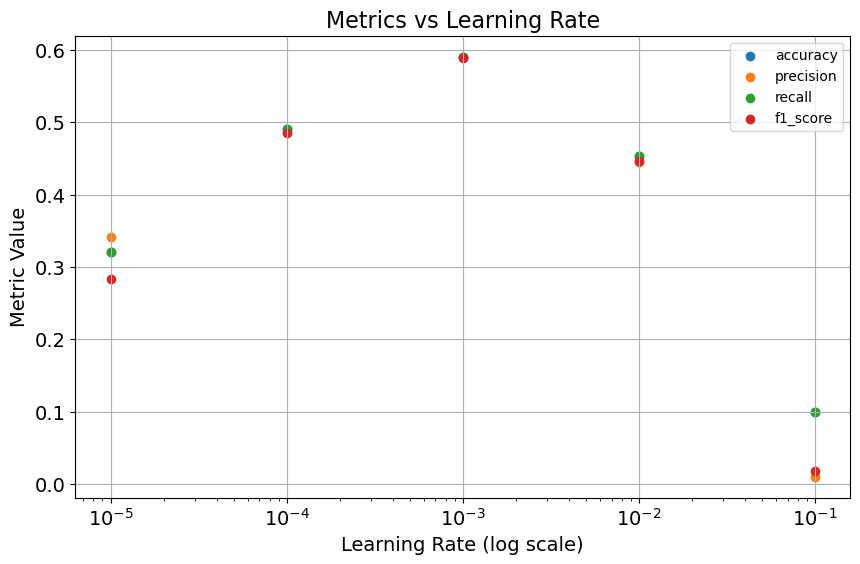

In [10]:
dict_metrics = []

# Loop through different learning rates and collect metrics
for lr in learning_rates:

    # Train and evaluate the model, collecting metrics, for a given learning rate
    n_epochs = 25
    batch_size = 128
    acc, prec, rec, f1 = train_and_evaluate_metrics(learning_rate=lr, device=device, n_epochs=n_epochs, batch_size=batch_size)

    metrics_lr = {
        "learning_rate": lr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }

    dict_metrics.append(metrics_lr)

# Convert the list of dictionaries to a DataFrame for easier plotting
df_metrics = pd.DataFrame(dict_metrics)

helper_utils.plot_metrics_vs_learning_rate(df_metrics)